# **TP 4 : Filtrage fréquentiel**

**Nom & Prénom** :

*  Imad Anis KHEFFACHE



**Spécialité** :  Data Science & Intelligence Artificielle

In [3]:
# Importation des bibliothèques nécessaires

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import cmath
import os
from google.colab.patches import cv2_imshow
import skimage.measure as skm
import scipy.misc
from scipy import ndimage
from skimage.util import random_noise
import random

**1 et 2: Affichage et transformation en niveaux de gris:**

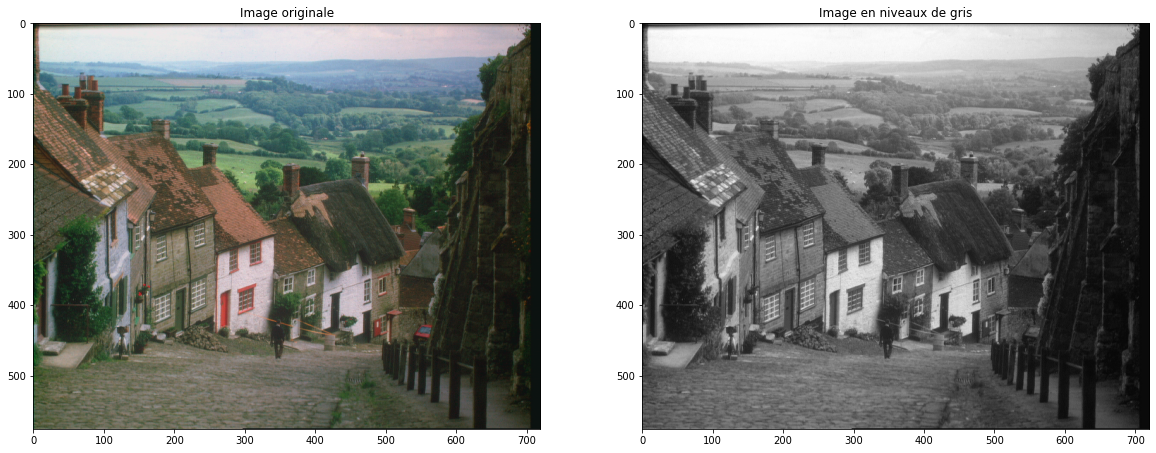

In [5]:
plt.figure(figsize = (20, 20))    #Toujours ajuster

img=cv.imread('goldhill.bmp')
img=cv.cvtColor(img, cv.COLOR_BGR2RGB)     #Inverser les canaux pour l'affichage en RGB
plt.subplot(1,2,1)
plt.title('Image originale')
plt.imshow(img)

image=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.subplot(1,2,2)
plt.title('Image en niveaux de gris')
plt.imshow(image, cmap='gray')

**3/ Ajout du bruit gaussien:**

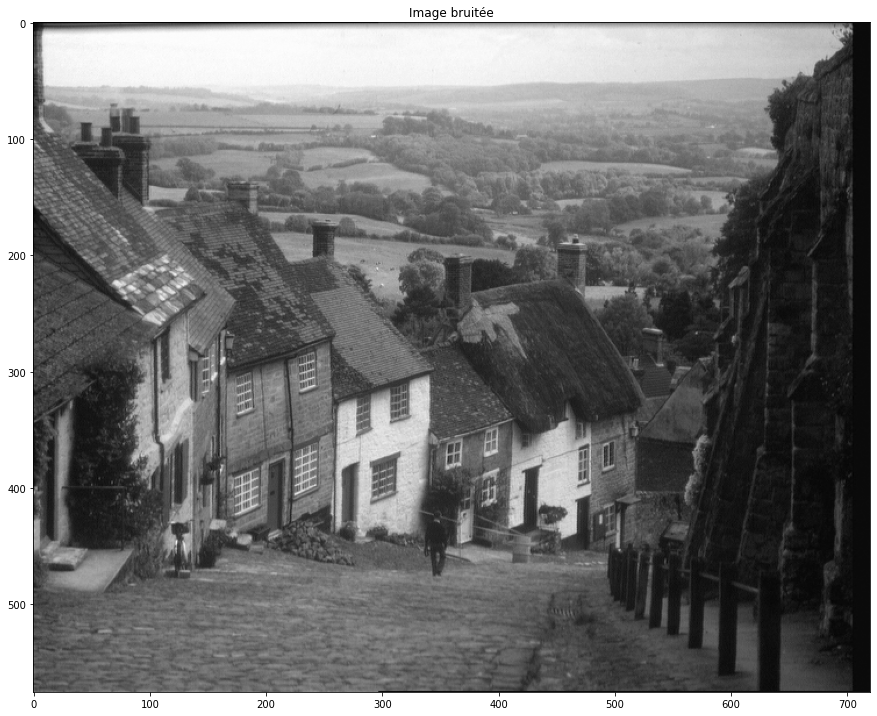

In [6]:
plt.figure(figsize = (15, 15))

#Création du bruit gaussien

def BruitGaussien(image, mu, sigma):
    row,col=image.shape
    gauss=np.random.normal(mu,sigma,(row,col))
    bruitée=image+gauss
    return bruitée

bruitée=BruitGaussien(image,0,0.01)
bruitée=np.uint8(bruitée)
plt.title('Image bruitée')
plt.imshow(bruitée, cmap="gray") 

On remarque que le bruit ajouté à l'image n'est presque pas visible puisque l'écart-type du bruit ajouté est très petit pour être discernable (sachant que la discernabilité du bruit et son écart-type quand il est gaussien sont proportionnels).

**4/ Transformée de Fourier discrète:**

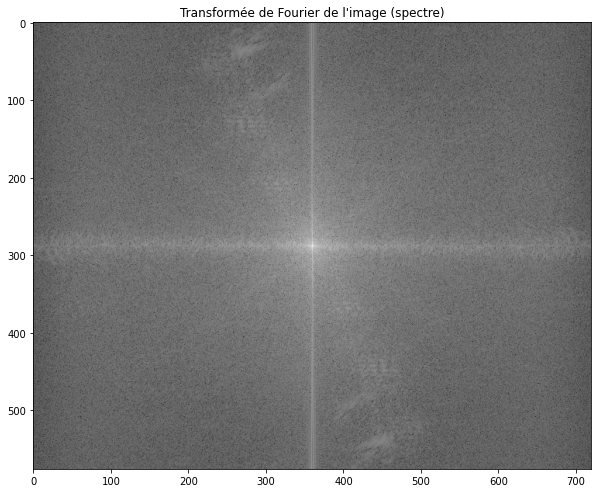

In [71]:
plt.figure(figsize = (10, 10))      # Réajuster la taille de l'image

f=np.fft.fft2(bruitée)
fshift=np.fft.fftshift(f)
magnitude_spectrum=20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum,cmap='gray')
plt.title('Transformée de Fourier de l\'image (spectre)')
plt.show()

C'est une transformée de Fourier bi-dimensionnelle, ce qui est logique vu que l'image est un signal à 2 dimensions.

**5/ Fonction de transfert H:**

Text(0.5, 1.0, 'Fonction de transfet H (du filtre)')

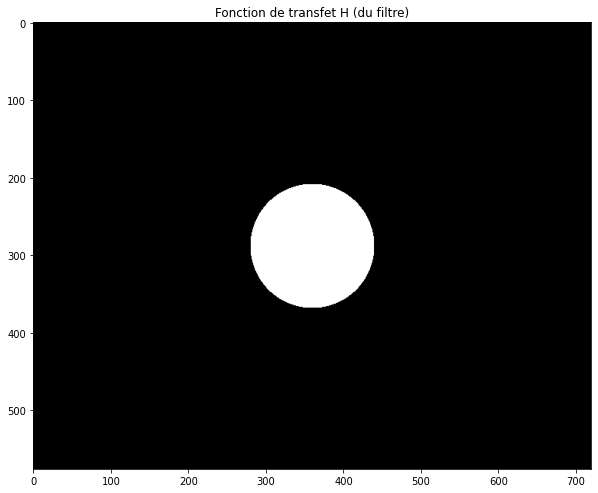

In [64]:
plt.figure(figsize = (10, 10))

nl,nc=bruitée.shape 
D0=80            #D0 fréquence de coupure du filtre 
x = np.arange(-nl/2,nl/2,1)
y = np.arange(-nc/2, nc/2, 1)
xx, yy = np.meshgrid(y, x, sparse=True) 
z = np.sqrt(xx*xx+yy*yy) 
H = z<D0
# C'est la transformée de Fourier discrète d'un filtre fréquentiel passe-bas idéal
plt.imshow(H,cmap='gray')
plt.title('Fonction de transfet H (du filtre)')

On remarque que la fonction de transfert qui a été fournie correspond à la TFD d'un filtre passe-bas idéal vu que ça fonctionne avec un rayon sur le domaine fréquentiel de l'image. Dans ce spectre, toutes les fréquences en dehors du cercle de rayon D0 sont coupées et seules les fréquences à l'intérieur qui sont gardées (Couleur noire: amplitude nulle, Couleur blanche: aucune modification du module de la TFD pour cette fréquence), ce qui correspond parfaitement à la description d'un filtre passe-bas idéal.

**6/ Multiplication des spectres:**

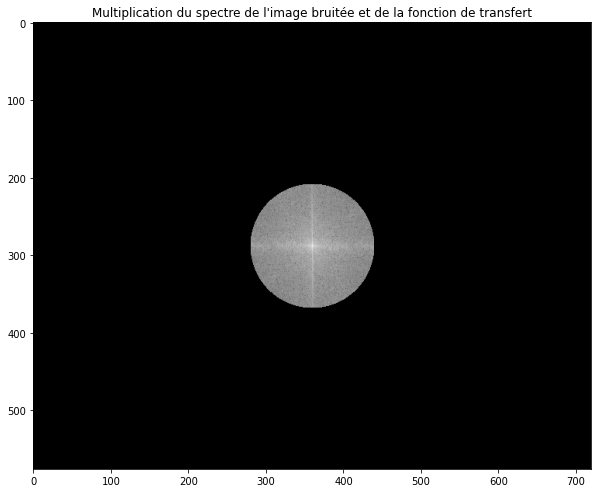

In [65]:
plt.figure(figsize = (10, 10))

mul=H*magnitude_spectrum
plt.imshow(mul, cmap='gray')
plt.title('Multiplication du spectre de l\'image bruitée et de la fonction de transfert')
plt.show()

On remarque donc, et comme prévu lors de la question précédente, que seule la région du spectre qui était dans le disque de rayon D0 qui est restée après multiplication par la fonction de transfert H.

**7/ Transformée de Fourier inverse:**

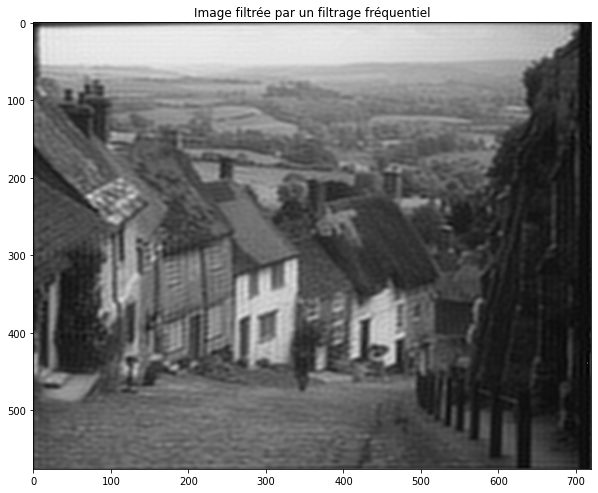

In [66]:
plt.figure(figsize = (10, 10))

f_ishift = np.fft.ifftshift(fshift*H) 
img_back = np.fft.ifft2(f_ishift) 
img_back = np.real(img_back) 
img_back=np.uint8(img_back) 
plt.imshow(img_back,cmap='gray')
plt.title('Image filtrée par un filtrage fréquentiel')
plt.show()

On remarque que l'image est floutée; cela est cohérent car nous venons d'utiliser un filtrage passe-bas qui enlève les hautes fréquences qui représentes les nettes variations en niveaux de gris (autrement dit, majoritairement les contours), et donc ce filtre contribuera à enlever les contours et donc à lisser l'image et la flouter, Les résultats sont cohérents. </br> On remarque aussi de légères oscillations sur l'image obtenue, ce qui revient à la nature du filtre idéal (qui fait une transition brutale entre les fréquences à inclure et celles non); la transition brutale correspond à un signal carré dans le domaine fréquentiel et donc après avoir effectué la TFD inverse, la TF Inverse d'un signal carré est un sinus cardinal; et c'est donc par cela qu'on explique les oscillations qu'on arrive à discerner.

**8/ Filtrage passe-haut:**

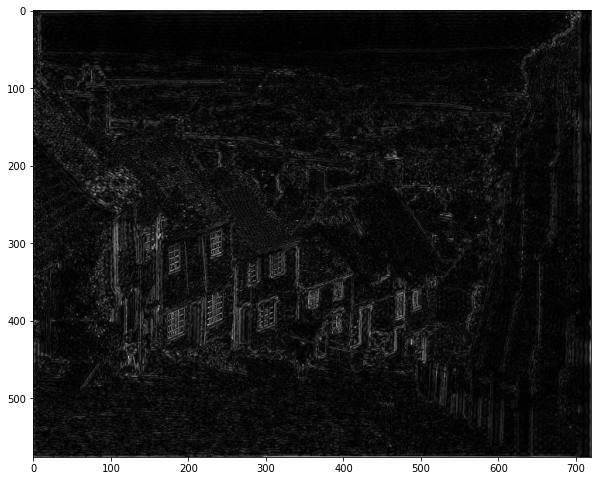

In [68]:
plt.figure(figsize = (10, 10))

nl, nc = bruitée.shape

D0=60
x=np.arange(-nl/2, nl/2, 1)
y=np.arange(-nc/2, nc/2, 1)
xx, yy=np.meshgrid(y, x, sparse=True)
z=np.sqrt(xx * xx + yy * yy)
H=z > D0

passe_haut=magnitude_spectrum*H

f_ishift = np.fft.ifftshift(fshift*H)
img_back = np.fft.ifft2(f_ishift)
img_back = np.absolute(img_back)
img_back = np.uint8(img_back)
plt.imshow(img_back,cmap='gray')

On remarque qu'il n'y a que les contours qui sont restés sur l'image, ce qui est cohérent avec le filtrage idéal passe-haut qu'on a appliqué. Un filtre passe-haut coupe les basses fréquences qui sont des variations graduées des niveaux de gris (zones homogènes dans l'image) et garde les hautes qui correspondent à des variations nettes et brutales des niveaux de gris (les contours) ce qui est ce qui s'est reflété dans l'image. On remarque aussi de légères oscillations dans l'image qui sont dûes à la nature du filtre idéal (passage brutal entre les fréquences).

**9/ Filtrage passe-bande:**

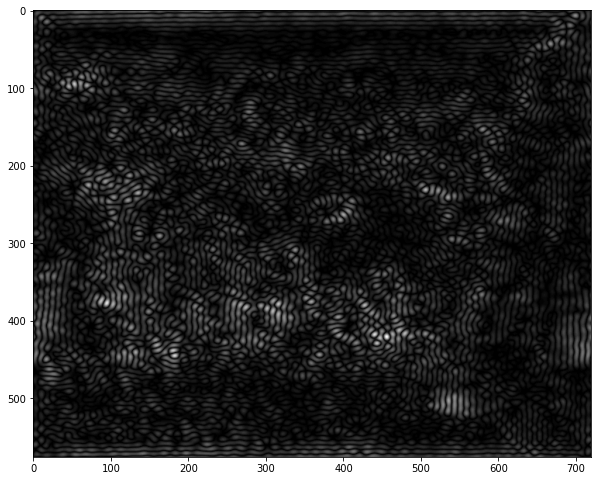

In [70]:
plt.figure(figsize = (10, 10))

#Ne laisser passer qu'une partie au milieu des fréquences

nl,nc=bruitée.shape

D0=40
D1=60
x=np.arange(-nl/2, nl/2, 1)
y=np.arange(-nc/2, nc/2, 1)
xx, yy=np.meshgrid(y, x, sparse=True)
z=np.sqrt(xx*xx+yy*yy)
H=(D0<z)&(z<D1)

passe_bande=magnitude_spectrum*H

f_ishift=np.fft.ifftshift(fshift*H)
img_back=np.fft.ifft2(f_ishift)
img_back=np.absolute(img_back)
img_back=np.uint8(img_back)

plt.imshow(img_back, cmap='gray')

On remarque ici que l'image filtrée est un peu du n'importe quoi et ce car le filtre qui a été appliqué est un filtre passe-bande (qui laisse passer une bande de fréquences au milieu de l'intervalle), généralement on l'utilise quand on veut faire ressortir un aspect partculier de l'image (Dans ce cas, il y a aucun aspect qui ressort particulièrement, faudrait, si il y a quelque chose à faire ressortir, changer les bornes de filtrage; sinon on change carrément de type de filtrage). </br> Dans ce cas, le filtre passe-bande est caractérisé par un mélange des caractéristiques des 2 filtres (passe-haut et passe-bas) dans le sens ou on a un lissage des contours (qui n'ont plus une forme filiforme) et ou il y a des zones homogènes qui ont été enlevées par le filtre; on remarque aussi une présence d'oscillations qui est dûe au passage brutal entre les fréquences prises et non prises dans le spectre de l'image aux bornes supérieure et inférieure du domaine de fréquences prises. C'est tout à fait cohérent avec ce que peut faire un filtre passe-bande.

**10/ Conclusion:**  </br>
En résumé, le filtrage fréquentiel est un processus qui consiste à modifier le spectre d'une image en travaillant dans le domaine fréquentiel. Il permet de contrôler l'effet appliqué à chaque fréquence de l'image, ce qui peut entraîner une atténuation ou une amplification des fréquences. Il y a trois types de filtres fréquentiels: passe-bas, passe-haut et passe-bande. Les filtres passe-bas conservent les basses fréquences et suppriment les hautes fréquences, ce qui donne une image lissée. Les filtres passe-haut, quant à eux, conservent les hautes fréquences et suppriment les basses fréquences, ce qui est souvent utilisé pour extraire les contours. Les filtres passe-bande ne laissent passer qu'une plage spécifique de fréquences souvent utilisés pour faire ressortir un aspect particulier de l'image. </br>La décision de quel filtre prendre dépend tout à fait de ce qu'on veut faire avec notre image.